### Modeling Water Quality of the Potomac River
#### Predicting Total Phosphorus Levels 

**Imports**

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# code modified from Mike Blow's RandomForestRegressor model

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [3]:
np.random.seed(20200908)

In [44]:
water = pd.read_csv('./data/WQ_FINAL_with_Parameters.csv')

In [45]:
cols = water.columns
params = [col for col in cols if 'Parameter' in col]

**Transform Variables**

A decision tree based model can handle cathegorical variables without turning them into binary variables ==> we do not turn HUC12_ and SampleId into dummies.

In [6]:
# create dummy variables for HUC12_
# water = pd.get_dummies(water, columns=['HUC12_'], prefix='huc12', drop_first=True)

In [46]:
# create dummy variables for TideStage
water = pd.get_dummies(water, columns=['TideStage'], prefix='tide', drop_first=True)

In [8]:
# create dummy variables for SampleId
# water = pd.get_dummies(water, columns=['SampleId'], prefix='sample')

In [47]:
# transform Date_Time into datetime object
water['Date_Time'] = pd.to_datetime(water['Date_Time'])

In [48]:
# create variables for year and for month
water['Years'] = water['Date_Time'].dt.year
water['Months'] = water['Date_Time'].dt.month

In [49]:
# export transformed dataframe
# water.to_csv('./data/Potomac_transformed.csv', index=False)

**Correlation Matrix**

In [10]:
water.columns

Index(['Date_Time', 'SampleId', 'SampleDepth', 'Agency', 'Cruise', 'Database',
       'HUC12', 'Latitude', 'Layer', 'Longitude', 'Method', 'Program',
       'Project', 'SampleReplicateType', 'SampleType', 'Source', 'Station',
       'TierLevel', 'Unit', 'Point', 'HUC12_', 'HUCNAME_', 'FIPS_', 'COUNTY_',
       'STATE_', 'TotalDepth', 'Parameter_CHLA', 'Parameter_DO',
       'Parameter_NH4F', 'Parameter_NO3F', 'Parameter_PH', 'Parameter_PO4F',
       'Parameter_SALINITY', 'Parameter_SECCHI', 'Parameter_TALK',
       'Parameter_TDS', 'Parameter_TKNW', 'Parameter_TN', 'Parameter_TP',
       'Parameter_TSS', 'Parameter_TURB_NTU', 'Parameter_WTEMP',
       'tide_Flood Tide', 'tide_High Slack Tide', 'tide_Low Slack Tide',
       'Years', 'Months'],
      dtype='object')

In [13]:
# cols = water.columns
# sample_variables = [col for col in cols if 'sample' in col]

In [14]:
# huc_variables = [col for col in cols if 'huc' in col]

In [18]:
# variables to correlate with Parameter_TP

water_corr = water.drop(columns=['SampleId', 'Date_Time', 'Agency', 'Cruise', 'Database', 'HUC12',
             'Latitude', 'Layer', 'Longitude', 'Method',
             'Program', 'Project', 'SampleReplicateType', 'SampleType',
             'Source', 'Station', 'TierLevel', 'Unit', 'Point',
             'HUCNAME_', 'FIPS_', 'COUNTY_', 'STATE_', 'TotalDepth'
            ])

In [19]:
# water_corr = water_corr.drop(columns=sample_variables)

In [17]:
# water_corr.drop(columns=huc_variables, inplace=True)

In [20]:
water_corr.shape

(29774, 23)

In [21]:
# correlation matrix
water_corr.corr()

,SampleDepth,HUC12_,Parameter_CHLA,Parameter_DO,Parameter_NH4F,Parameter_NO3F,Parameter_PH,Parameter_PO4F,Parameter_SALINITY,Parameter_SECCHI,...,Parameter_TN,Parameter_TP,Parameter_TSS,Parameter_TURB_NTU,Parameter_WTEMP,tide_Flood Tide,tide_High Slack Tide,tide_Low Slack Tide,Years,Months
SampleDepth,1.000000,0.298364,-0.051237,-0.246909,0.010671,-0.139905,0.047496,-0.031205,0.412746,-0.289386,...,-0.095798,0.013467,0.020906,0.009164,-0.002560,-0.126211,-0.011693,-0.035440,0.088154,-0.021554
HUC12_,0.298364,1.000000,0.056390,-0.234133,-0.147033,-0.386257,-0.018793,-0.141175,0.414872,0.077783,...,-0.286870,-0.107803,-0.084925,-0.059218,0.150584,-0.318314,0.040491,0.040664,-0.149033,0.018919
Parameter_CHLA,-0.051237,0.056390,1.000000,0.060347,0.086285,0.105260,0.018954,0.123710,-0.093204,0.155105,...,0.296343,0.312077,0.192736,0.137265,0.052292,-0.035137,0.041375,0.010280,0.018863,-0.051131
Parameter_DO,-0.246909,-0.234133,0.060347,1.000000,0.016819,0.296525,0.349397,-0.025177,-0.249128,0.014052,...,0.242648,0.076246,0.089224,0.095288,-0.561552,0.071635,0.011070,0.031532,0.182693,-0.299963
Parameter_NH4F,0.010671,-0.147033,0.086285,0.016819,1.000000,0.388296,-0.013437,0.370214,-0.159301,0.099321,...,0.487142,0.354084,0.211213,0.223065,-0.070302,0.036930,-0.012965,-0.011521,-0.008756,-0.047727
Parameter_NO3F,-0.139905,-0.386257,0.105260,0.296525,0.388296,1.000000,-0.002388,0.451571,-0.424761,0.033627,...,0.891921,0.508278,0.317726,0.306944,-0.257763,0.182901,-0.074527,-0.046551,0.156672,-0.133189
Parameter_PH,0.047496,-0.018793,0.018954,0.349397,-0.013437,-0.002388,1.000000,-0.011115,0.103022,-0.105580,...,0.009027,-0.017780,-0.011547,0.024804,0.184529,-0.013234,0.022240,0.036448,-0.001175,-0.026594
Parameter_PO4F,-0.031205,-0.141175,0.123710,-0.025177,0.370214,0.451571,-0.011115,1.000000,-0.194181,0.088213,...,0.577401,0.675833,0.287533,0.261265,0.057468,0.076268,-0.077300,-0.056797,0.028388,0.112858
Parameter_SALINITY,0.412746,0.414872,-0.093204,-0.249128,-0.159301,-0.424761,0.103022,-0.194181,1.000000,-0.054703,...,-0.352559,-0.214836,-0.169872,-0.214561,0.097536,-0.108372,-0.045898,-0.044655,-0.041905,0.115371
Parameter_SECCHI,-0.289386,0.077783,0.155105,0.014052,0.099321,0.033627,-0.105580,0.088213,-0.054703,1.000000,...,0.134846,0.097663,0.015345,0.012274,-0.013392,-0.053579,0.036573,0.077743,-0.058363,0.034233


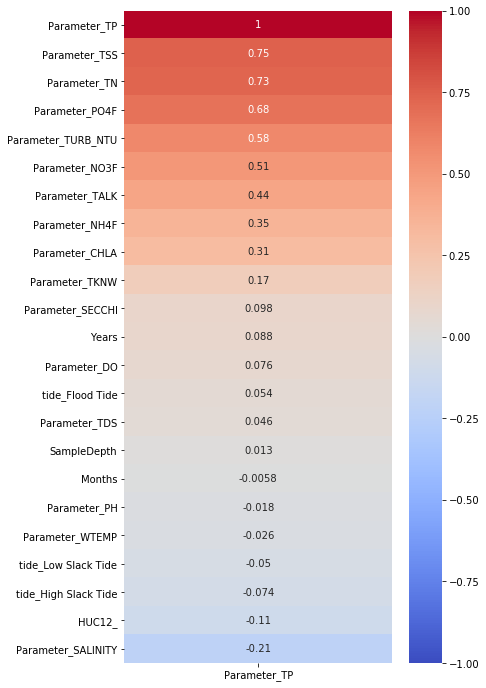

In [22]:
# heatmap to display correlation matrix
plt.figure(figsize=(6, 12))
sns.heatmap(water_corr.corr()[['Parameter_TP']].sort_values('Parameter_TP', ascending=False),
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            annot=True);
plt.show();

### Random Forest Classifier
- categorical total phosphorus as y variable

Categories:
- 0.01 - 0.03 mg/L - uncontaminated freshwater
- 0.025 - 0.1 mg/L - level at which plant growth is stimulated
- \> 0.1 mg/L - accelerated growth and consequent problems


[source](https://water-research.net/index.php/phosphates)

In [23]:
# function to create categorical total phosphorus

def categorical_TP(column):
    if column < 0.03:
        # value for uncontaminated water = 1
        value = 1
    elif column <= 0.1:
        # value for stimulated plant growth = 2
        value = 2
    elif column > 0.1:
        # value for problematic total phosphorus level = 3
        value = 3
    return value

In [24]:
# create categorical TP variable
water['Categorical_TP'] = water['Parameter_TP'].map(categorical_TP)

In [25]:
water['Categorical_TP'].isna().sum()

0

In [26]:
# columns to drop from features
col_to_drop = ['Date_Time', 'Agency', 'Cruise', 'Database', 'HUC12', 'Latitude', 'Layer', 'Longitude', 'Method', 'Program', 'Project', 
               'SampleReplicateType', 'SampleType', 'Source', 'Station', 'TierLevel', 'Unit', 'Point', 'FIPS_', 'COUNTY_', 'STATE_', 'Parameter_TP',
               'Categorical_TP', 'HUCNAME_']

In [27]:
X = water.drop(columns=col_to_drop)

y = water['Categorical_TP']

**Baseline Accuracy**

In [28]:
y.value_counts(normalize=True)

1    0.759320
2    0.209444
3    0.031235
Name: Categorical_TP, dtype: float64

**Model**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42,
                                                    stratify=y)

In [30]:
rf = RandomForestClassifier()

In [31]:
# parameters for grid search
params = {
    'n_estimators'      : [100, 200, 300],
    'min_samples_split' : [10, 20, 30],
    'max_depth'         : [None, 5, 10]
}

In [32]:
# Set up grid search
gs = GridSearchCV(rf, 
                  param_grid=params, 
                  return_train_score=True, 
                  cv = 5)

In [33]:
# Run grid search on training data with a time check. WARNING: this search takes ~ 8 min. with n_jobs=6
import time
t0 = time.time()
gs.fit(X_train, y_train)
print(time.time() - t0)

361.7950358390808


# Evaluation

In [50]:
# Score on training set.
train_accuracy = gs.score(X_train, y_train)

In [51]:
# Score on testing set.
test_accuracy = gs.score(X_test, y_test)

In [52]:
# List best hyperparameters found in Grid Search
gs.best_params_

{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}

In [53]:
# 5-fold cross validation score.
gs.best_score_

0.9688190016279103

In [54]:
# Utilize model to get predictions on testing set.
preds = gs.predict(X_test)

In [55]:
# List scores from best features in model
gs.best_estimator_.feature_importances_

array([0.01231978, 0.03150362, 0.01786509, 0.02722533, 0.07935156,
       0.01510751, 0.07730186, 0.05941334, 0.00688961, 0.19844834,
       0.00927197, 0.00816391, 0.03124696, 0.00235435, 0.00707501,
       0.19539278, 0.11777799, 0.06763014, 0.0176866 , 0.00108419,
       0.00032581, 0.00023168, 0.00934726, 0.00698531])

In [56]:
# Grab feature names, their importance, and sort them into a dataframe.
features_df = pd.DataFrame(gs.best_estimator_.feature_importances_, X_train.columns, columns=['Importance'])
features_df.sort_values(by='Importance', ascending=False).head(25)

,Importance
Parameter_PO4F,0.198448
Parameter_TN,0.195393
Parameter_TSS,0.117778
Parameter_CHLA,0.079352
Parameter_NH4F,0.077302
Parameter_TURB_NTU,0.067630
Parameter_NO3F,0.059413
SampleDepth,0.031504
Parameter_TALK,0.031247
TotalDepth,0.027225


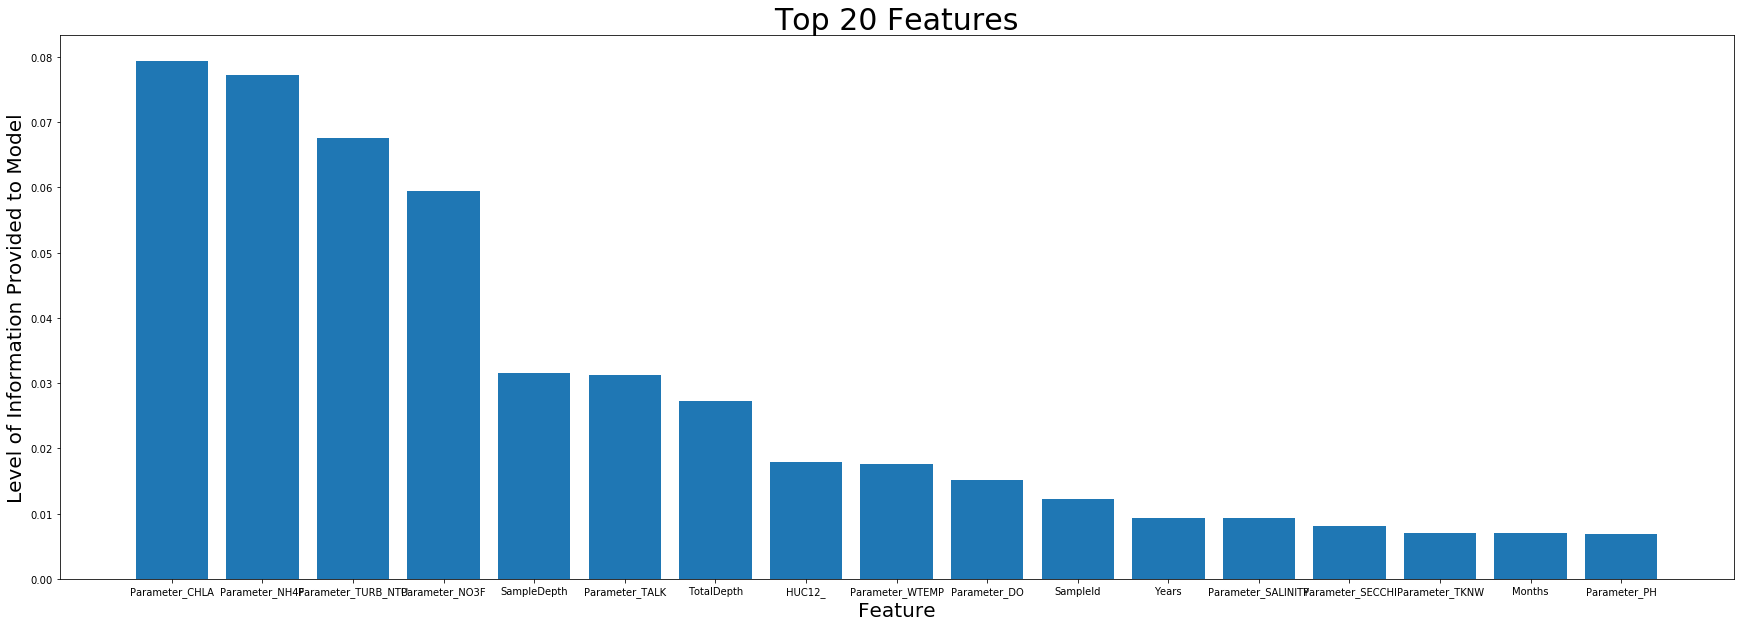

In [57]:
# plot the top features minus the top 3 ('leadership', 'leader', & 'leaders')
plt.figure(figsize=(30,10))
temp = features_df.sort_values('Importance', ascending=False).head(20)
plt.bar(temp.index[3:], temp['Importance'][3:])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Feature', fontsize=20)
plt.ylabel('Level of Information Provided to Model', fontsize=20);

In [58]:
# print accuracy scores
print(f'Traning accuracy: {round(train_accuracy, 2)}')
print(f'Testing accuarcy: {round(test_accuracy, 2)}')
print('Cross-validated accuracy:', round(gs.best_score_, 2))

Traning accuracy: 0.99
Testing accuarcy: 0.97
Cross-validated accuracy: 0.97


The model is slightly overfit to the training data, however, the cross-validated accuracy score supports the 97% testing accuracy. The model seems to generalize well in predicting the total_phosphorus categories of healthy level, level of promoting plant growth, and alarmingly high level that may lead to rapid plant growth such as algea bloom and eutrophication.

In [66]:
# generate confusion matrix
confusion_matrix = confusion_matrix(y_test,
                 preds)

# source for code from Matt Brems, lesson on classification metrics
# https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

**Problematic Phosphorus Level**

In [67]:
confusion_matrix

array([[7369,   92,    0],
       [  89, 1946,   23],
       [   0,   92,  215]])

In [69]:
# true positive for the problematic phosphorus level
TP = confusion_matrix[2][2]
print(f'True positive value: {TP}')

True positive value: 215


In [72]:
# true negative for the problematic phosphorus level
TN = confusion_matrix[0][0] + confusion_matrix[0][1] + confusion_matrix[1][0] + confusion_matrix[1][1]
print(f'True negative value: {TN}')

True negative value: 9496


In [70]:
# false positive for the problematic phosphorus level
FP = confusion_matrix[0][2] + confusion_matrix[1][2]
print(f'False positive value: {FP}')

False positive value: 23


In [71]:
# false negative for the problematic phosphorus level
FN = confusion_matrix[2][0] + confusion_matrix[2][1]
print(f'False negative value: {FN}')

False negative value: 92


In [73]:
# calculate sensitivity = the rate of true positives out of all positive predictions 
# ie. the rate of all those observations that the model predicted as problematic level of total phosphorus while being true
# out of all those cases when the level of total phosphorus was problematic
print(f'Sensitivity of the model when predicting problematic phosphorus levels: {TP/ (TP + FN)}')

Sensitivity of the model when predicting problematic phosphorus levels: 0.7003257328990228
